# Перевоспитываем модельку генерить интегралы

Идея пришла внезапно, мотивация:

1) захотелось потыкаться в то, как диффузия работает

2) возможно в будущем мне понадобится интегральный датасет, так что полезно его сейчас собрать

## Начнём с данных

Было 2 основных идеи, как собирать датасет

1) синтетика

2) парсить

Я начал с более сложной:

* взял `YOLO` и задачник Демидовича

* разметил в `CVAT` 200 интегралов

* прогнал через ёлку 3 главы про интегралы, собрал что-то около 1200 штук

* понял что надо их перевести в латех

* $\dots$

* профит

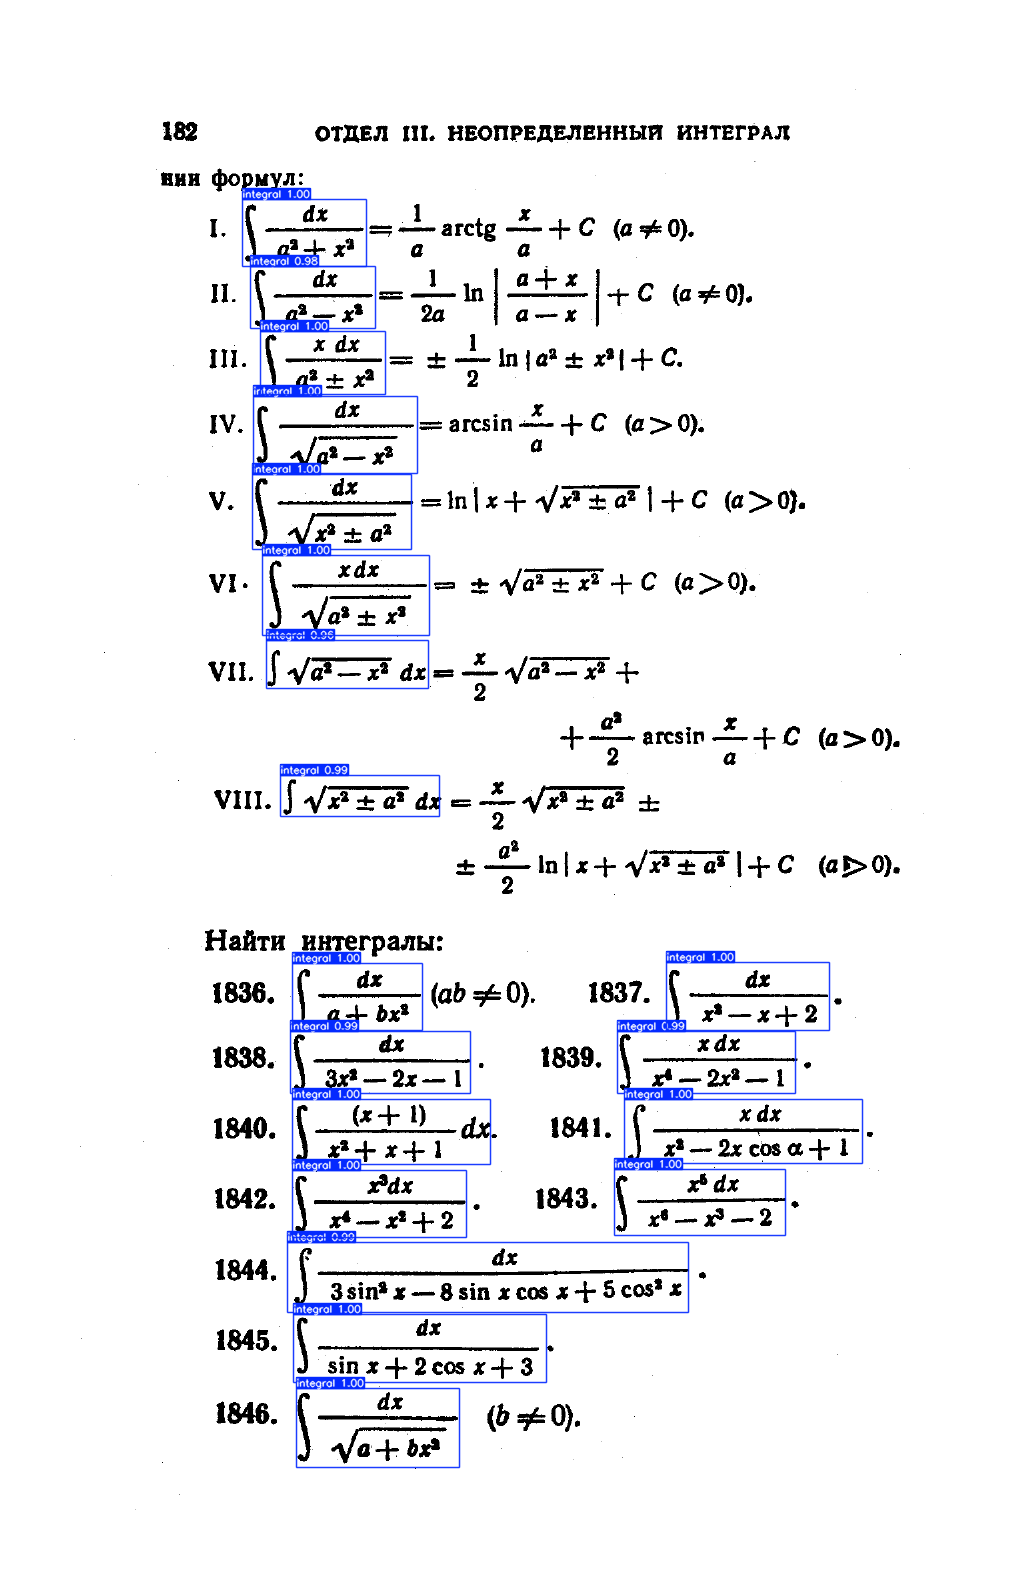

Ну в общем да, я взял очень плохого качества скан и не подумал что это нужно как-то расшифровывать...

И даже если были бы норм картинки, всё ещё надо будет фиксить разметку

### Как в итоге сделал

Нашёл [на просторах интернета](https://www.physics.umd.edu/hep/drew/IntegralTable.pdf) брошюру `table of integrals`

В ней 133 разных интеграла и она есть в $\LaTeX$

Попросил Gemini переписать её в формат `csv`, получил 133 тренировочных примера

Заметил, что в интегралах есть параметры $\left(\int (ax + b)^2 dx\right)$, выписал эти параметры в колонку в csv, написал генератор, получил кучу синтетики

В итоге нагенерил 3000 примеров, можно и больше сделать

In [11]:
import pandas as pd
path = "/home/ananasclassic/projects/CV_project/"
pd.read_csv( path + 'data/book_of_integrals.csv')

,Section,Integral (LHS),Result (RHS),parameter
0,Basic Forms,\int x^n dx,"\frac{1}{n+1}x^{n+1},\hspace{1ex}n\neq -1","""n"""
1,Basic Forms,\int \frac{1}{x} dx,\ln |x|,""""""
2,Basic Forms,\int u dv,uv - \int v du,""""""
3,Basic Forms,\int \frac{1}{ax+b} dx,\frac{1}{a} \ln |ax + b|,"""a b"""
4,Integrals of Rational Functions,\int \frac{1}{(x+a)^2} dx,-\frac{1}{x+a},"""a"""
...,...,...,...,...
129,Integrals of Hyperbolic Functions,\int \cos ax \sinh bx dx,\frac{1}{a^2 + b^2} \left[ b \cos ax \cosh bx ...,"""a b"""
130,Integrals of Hyperbolic Functions,\int \sin ax \cosh bx dx,\frac{1}{a^2 + b^2} \left[ -a \cos ax \cosh bx...,"""a b"""
131,Integrals of Hyperbolic Functions,\int \sin ax \sinh bx dx,\frac{1}{a^2 + b^2} \left[ b \cosh bx \sin ax ...,"""a b"""
132,Integrals of Hyperbolic Functions,\int \sinh ax \cosh ax dx,\frac{1}{4a}\left[ -2ax + \sinh 2ax \right],"""a"""


### А как делать изображения?
`matplotlib` немножко умеет в `LaTeX`, этого достаточно

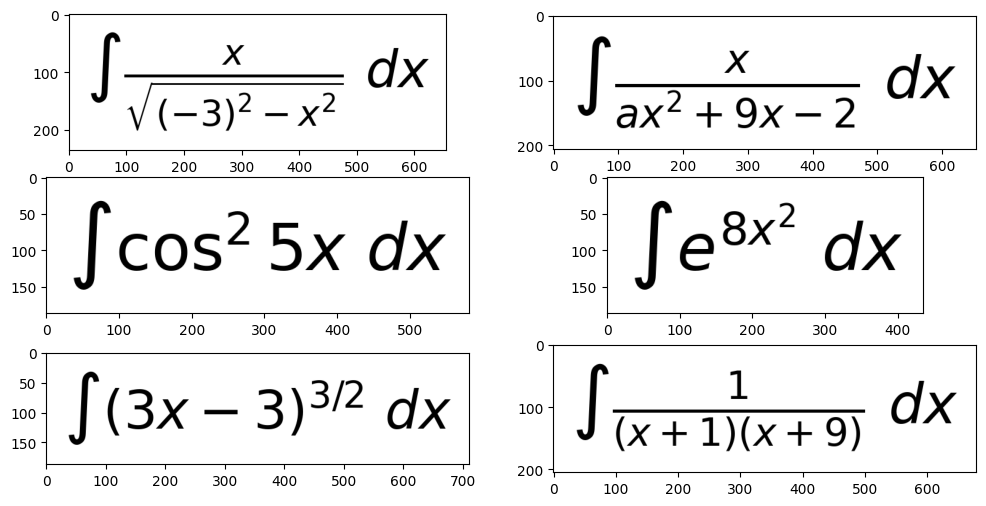

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, 2, figsize=(12, 6))
for i in range(6):
    img = plt.imread(f'/home/ananasclassic/projects/CV_project/data/synt/images/img_000000{i}.png')
    ax[i // 2, i % 2].imshow(img)

### Окей, что учить будем?

Решил просто сделать `LoRa` над какой-нибудь моделькой на 1-3B

тут редкое счастье, когда есть А100, а думать лень, почему бы не воспользоваться

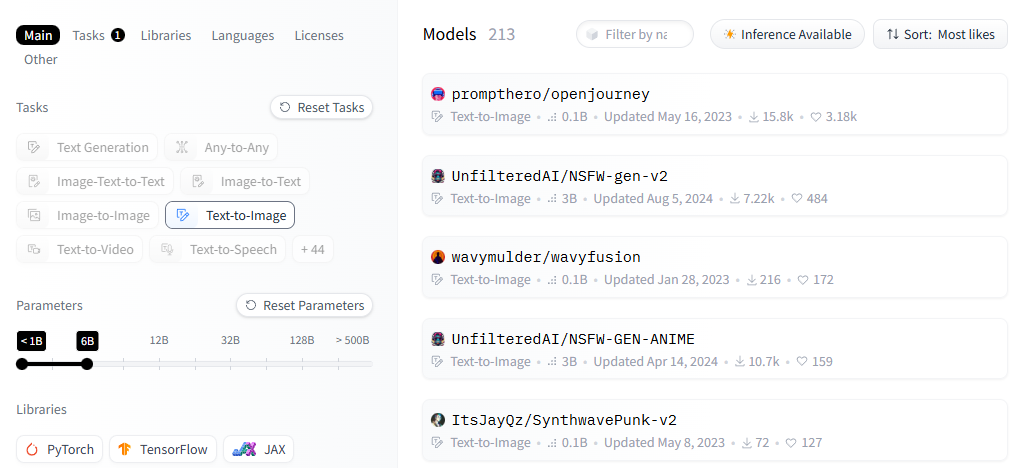

Ага, вторая модель как раз подходит по размеру, да и вышла позже других, её и возьму.

'law bias' $\ne$ 'low bias'

### А как учим?

### Весёлые формулы лосса

Для начала возбмём стандартный диффузионный лось

добавим `loss_img` -- восстанавливаем изображение из латента и считаем `L1` \
Почему? потому что у нас есть правильный ответ, ~~в отличие от диффузии здорового человека~~ :)

Нам нужно переучить нейронку с красивых сочных картинок на чб c чёткими границами. \
Чтобы загнать её в чёткие рамки применим фильтр собеля, и посчитаем `L1`

### $\mathcal L = \mathcal L_{\text{diff}} + \lambda_{\text{img}}\mathcal L_{\text{img}} + \lambda_{\text{edge}}\mathcal L_{\text{edge}}$

Когда тренил взял \
$\lambda_{\text{img}} = 0.05$ \
$\lambda_{\text{edge}} = 0.05$

А, и ещё прикрутим `min-SNR`, чтобы быстрее куда-то сойтись

### Что осталось за кадром?

там была ещё пара слагаемых

там был весёлый этап с `ocr` -- берём вторую модельку для распознавания латеха и смотрим что получится после её применения к выходу \
Это жестокий метод заставлять модель генерить правильные символы. \
Минусы? Это не работает на данном этапе трейна, т.к. (имхо) градиенты шумные, и cама моделька латеха не всегда норм справляется, так что мы учимся генерить мусор который её сбивает

Было б больше сил и понимания, возможно прикольно было бы припилить `RL` или свести к `GAN`

### Результат

<img src="./lora_integrals/samples/grid.png" height=600>

В принципе, есть что ещё можно доделать по качеству генерации, но для "тупой" LoRa в принципе неплохо

### Итоги

* У меня есть ёлка, которая ищет интегралы
* У меня есть неплохой синтетический датасет с интегралами, который можно расщирять
* Получилось обучить диффузию генерить что-то похожее на интегралы. В принципе, учитывая что это диффузия, неплохой результат